# Forecasting Energy Demand

## Preprocess

The project consists of two data sets:
* Hourly electricity demand data from the EIA;
* Hourly observed weather data from LCD/NOAA. 

Additionally to demand and weather data, I'll create features based on time to see how the trends are impacted by day of week, hour, time of year, if is holiday, etc.

To limit the scope of the project, I'll use data from Los Angeles exclusively to validate if is possible to improve electricity demand forecasting using weather data.

In [1]:
import requests
import json
import datetime
import pandas as pd
from scipy import stats
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

### Electricity data 
Electricity data were retrieved using EIA’s API and then unpacked into a dataframe. The API contain hourly entries from July 2015 to present.

The electricity data required just simple cleaning. There were few null values in the set and a very small number of outliers. Removing outliers cut only ~.01% of the data.

In [2]:
EIA__API_KEY = '1d48c7c8354cc4408732174250d3e8ff'
REGION_CODE = 'LDWP'
CITY = 'LosAngeles'

def str_to_isodatetime(string):
    year = string[:4]
    month = string[4:6]
    day =  string[6:8]
    time = string[8:11] + ':00:00+0000'
    return year + month + day + time

def eia2dataframe(response):
    '''
    This function unpacks the JSON file from EIA API into a pandas dataframe.
    '''
    data = response['series'][0]['data']
    dates = []
    values = []
    for date, demand in data:
        if demand is None or demand <= 0:
            dates.append(str_to_isodatetime(date))
            values.append(np.nan)      
            continue   
        dates.append(str_to_isodatetime(date))
        values.append(float(demand))
    df = pd.DataFrame({'datetime': dates, 'demand': values})
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['demand'] = df['demand'].interpolate()
    df.set_index('datetime', inplace=True)
    df.sort_index(ascending=True, inplace=True, kind='mergesort')
    return df

electricity_api_response = requests.get('http://api.eia.gov/series/?api_key=%s&series_id=EBA.%s-ALL.D.H' % (EIA__API_KEY, REGION_CODE)).json()
electricity_df = eia2dataframe(electricity_api_response)
electricity_df.head()


,demand
datetime,
2015-07-01 08:00:00+00:00,3298.0
2015-07-01 09:00:00+00:00,3045.0
2015-07-01 10:00:00+00:00,2892.0
2015-07-01 11:00:00+00:00,2787.0
2015-07-01 12:00:00+00:00,2790.0


### Observed weather data
LCD data are not available via NOAA’s API so I manually downloaded from the website as a CSV file which I imported to a pandas DataFrame. As common in data that come from physical sensors, LCD data required extensive cleansing.

The main challenges in cleaning the LCD data was that there were in some cases multiple entries for the same hour. I wanted to have just one entry per hour such that I could eventually align LCD data with the hourly entries in the electricity data.

I wrote a function that group weather data by hour and the mode of the entries for same hour. I performed the cleaning this way because either way, the values for multiple per-hour entries are very similar, so the choice of which entry to keep doesn’t make a real difference.


In [2]:
def mode_calc(x):
    try:
        print(stats.mode(x.dropna())[1][0])
        return stats.mode(x.dropna())[1][0]
    except IndexError:
        return np.nan

def fix_date(df):
    '''
    This function goes through the dates in the weather dataframe and if there is more than one record for each
    hour, we pick the record closest to the hour and drop the rows with the remaining records for that hour.
    This is so we can align this dataframe with the one containing electricity data.'''
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize('UTC')
    df['date_rounded'] = df['date'].dt.floor('H')
    df.drop('date', axis=1, inplace=True)
    df.rename({"date_rounded": "datetime"}, axis=1, inplace=True)
    df.set_index('datetime', inplace=True)
    # grouped_by_hour = df.groupby(['date_rounded']).head(-1)
    grouped_by_hour = df[~df.duplicated(keep='last') | ~df.duplicated(keep=False)]
    print(grouped_by_hour.dtypes)
    
    grouped_by_hour.sort_index(ascending=True, inplace=True, kind='mergesort')
    print(grouped_by_hour.shape)
    
    return grouped_by_hour
    
def clean_sky_condition(df):
    '''
    This function cleans the hourly sky condition column by assigning the hourly sky condition to be the one at the
    top cloud layer, which is the best determination of the sky condition, as described by the documentation.
    '''
    conditions = df['hourlyskyconditions']
    new_condition = []
    for k, condition in enumerate(conditions):
        if type(condition) != str and np.isnan(condition):
            new_condition.append(np.nan)
        else:
            colon_indices = [i for i, char in enumerate(condition) if char == ':']
            n_layers = len(colon_indices)
            try:
                colon_position = colon_indices[n_layers - 1]
                if condition[colon_position - 1] == 'V':
                    condition_code = condition[colon_position - 2 : colon_position]
                else:
                    condition_code = condition[colon_position - 3 : colon_position]
                new_condition.append(condition_code)
            except:
                new_condition.append(np.nan)

    df['hourlyskyconditions'] = new_condition
    df['hourlyskyconditions'] = df['hourlyskyconditions'].astype('category')
    return df

def hourly_degree_days(df):
    '''
    This function adds hourly heating and cooling degree days to the weather DataFrame.
    '''
    df['hourlycoolingdegrees'] = df['hourlydrybulbtemperature'].apply(lambda x: x - 65. if x >= 65. else 0.)
    df['hourlyheatingdegrees'] = df['hourlydrybulbtemperature'].apply(lambda x: 65. - x if x <= 65. else 0.)
    return df

# import csv
weather_df = pd.read_csv('data/LCD_1985258.csv', usecols=['DATE', 'DailyCoolingDegreeDays', 'DailyHeatingDegreeDays', 'HourlyDewPointTemperature', 'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlySkyConditions', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyDryBulbTemperature', 'HourlyWindSpeed'],
                        dtype={
                                'DATE': object,
                                'DailyCoolingDegreeDays': object,
                                'DailyHeatingDegreeDays': object,
                                'HourlyDewPointTemperature': object,
                                'HourlyPrecipitation': object,
                                'HourlyRelativeHumidity': object,
                                'HourlySeaLevelPressure': object,
                                'HourlySkyConditions': object,
                                'HourlyStationPressure': object,
                                'HourlyVisibility': object,
                                'HourlyDryBulbTemperature': object,
                                'HourlyWindSpeed': object
                        })

# make columns lowercase for easier access
weather_df.columns = [col.lower() for col in weather_df.columns]

# clean dataframe so that there's only one record per hour
weather_df = fix_date(weather_df)

# fill the daily heating and cooling degree days such that each hour in an individual day has the same value
weather_df['dailyheatingdegreedays'] = weather_df['dailyheatingdegreedays'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df.dailyheatingdegreedays.astype('float64')
weather_df['dailycoolingdegreedays'] = weather_df['dailycoolingdegreedays'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df.dailycoolingdegreedays.astype('float64')
weather_df['dailyheatingdegreedays'] = weather_df['dailyheatingdegreedays'].bfill()
weather_df['dailycoolingdegreedays'] = weather_df['dailycoolingdegreedays'].bfill()

weather_df = clean_sky_condition(weather_df)

# clean other columns by replacing string based values with floats
# values with an 's' following indicate uncertain measurments. we simply change those to floats and include them like normal
weather_df['hourlyvisibility'] = weather_df['hourlyvisibility'].apply(lambda x: float(x) if str(x)[-1] != 'V' else float(str(x)[:-1]))

weather_df['hourlydrybulbtemperature'] = weather_df['hourlydrybulbtemperature'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))

weather_df['hourlydewpointtemperature'] = weather_df['hourlydewpointtemperature'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))

# set trace amounts equal to zero and change data type
weather_df['hourlyprecipitation'].where(weather_df['hourlyprecipitation'] != 'T', 0.0, inplace=True)
weather_df['hourlyprecipitation'] = weather_df['hourlyprecipitation'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df['hourlystationpressure'] = weather_df['hourlystationpressure'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df['hourlywindspeed'] = weather_df['hourlywindspeed'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df['hourlyrelativehumidity'] = weather_df['hourlyrelativehumidity'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))
weather_df['hourlysealevelpressure'] = weather_df['hourlysealevelpressure'].apply(lambda x: float(x) if str(x)[-1] != 's' else float(str(x)[:-1]))

weather_df.hourlyprecipitation.astype('float64')
weather_df.hourlyvisibility.astype('float64')
weather_df.hourlyrelativehumidity.astype('float64')
weather_df.hourlysealevelpressure.astype('float64')
weather_df.hourlystationpressure.astype('float64')
weather_df.hourlywindspeed.astype('float64')

weather_df = hourly_degree_days(weather_df)

dailycoolingdegreedays       object
dailyheatingdegreedays       object
hourlydewpointtemperature    object
hourlydrybulbtemperature     object
hourlyprecipitation          object
hourlyrelativehumidity       object
hourlysealevelpressure       object
hourlyskyconditions          object
hourlystationpressure        object
hourlyvisibility             object
hourlywindspeed              object
dtype: object
(52262, 11)


In [4]:
weather_df.hourlyrelativehumidity.astype('float64')
weather_df.hourlysealevelpressure.astype('float64')

datetime
2015-07-01 00:00:00+00:00    29.85
2015-07-01 01:00:00+00:00    29.85
2015-07-01 02:00:00+00:00    29.89
2015-07-01 03:00:00+00:00    29.89
2015-07-01 04:00:00+00:00    29.89
                             ...  
2019-12-22 09:00:00+00:00    29.99
2019-12-22 10:00:00+00:00    29.99
2019-12-22 10:00:00+00:00    29.97
2019-12-22 11:00:00+00:00    29.94
2019-12-22 12:00:00+00:00    29.91
Name: hourlysealevelpressure, Length: 52262, dtype: float64

In [5]:
weather_df.dtypes

dailycoolingdegreedays        float64
dailyheatingdegreedays        float64
hourlydewpointtemperature     float64
hourlydrybulbtemperature      float64
hourlyprecipitation           float64
hourlyrelativehumidity        float64
hourlysealevelpressure        float64
hourlyskyconditions          category
hourlystationpressure         float64
hourlyvisibility              float64
hourlywindspeed               float64
hourlycoolingdegrees          float64
hourlyheatingdegrees          float64
dtype: object

In [6]:
print('*** min ***')
print(min(electricity_df.index))
print(min(weather_df.index))
print('*** max ***')
print(max(electricity_df.index))
print(max(weather_df.index))

*** min ***
2015-07-01 08:00:00+00:00
2015-07-01 00:00:00+00:00
*** max ***
2019-12-31 01:00:00+00:00
2019-12-22 12:00:00+00:00


In [7]:
## Cut dataframes based on date to align sources
cut_electricity = electricity_df[:weather_df.index.max()]
cut_weather = weather_df[cut_electricity.index.min():]

In [8]:
print('*** min ***')
print(min(cut_electricity.index))
print(min(cut_weather.index))
print(cut_weather.index.min() == cut_electricity.index.min())
print('*** max ***')
print(max(cut_electricity.index))
print(max(cut_weather.index))
print(cut_weather.index.max() == cut_electricity.index.max())

*** min ***
2015-07-01 08:00:00+00:00
2015-07-01 08:00:00+00:00
True
*** max ***
2019-12-22 12:00:00+00:00
2019-12-22 12:00:00+00:00
True


In [9]:
electricity_set = set(cut_electricity.index)
weather_set = set(cut_weather.index)
print(len(weather_set.difference(electricity_set)))
weather_set.difference(electricity_set)

242


{Timestamp('2018-06-30 08:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 09:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 10:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 11:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 12:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 13:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 14:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 15:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 16:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 17:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 18:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 19:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 20:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 21:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 22:00:00+0000', tz='UTC'),
 Timestamp('2018-06-30 23:00:00+0000', tz='UTC'),
 Timestamp('2018-07-01 00:00:00+0000', tz='UTC'),
 Timestamp('2018-07-01 01:00:00+0000', tz='UTC'),
 Timestamp('2018-07-01 02:00:00+0000', tz='UTC'),
 Timestamp('2018-07-01 03:00:00+0000', tz='UTC'),


## Dealing with outliers and NaN values

The plot distributions bof the features below is used to determine what columns should be filled by using the median
and which should be filled according to ffill. The features whose ```medians``` and ```means``` are close together suggest that the ```median``` is a good choice for NaNs.Conversely features whose median and means are further apart suggest the presence of outliers and in this case I use ```ffill``` because we are dealing with time series and values in previous time steps are useful in predicting values for later time steps

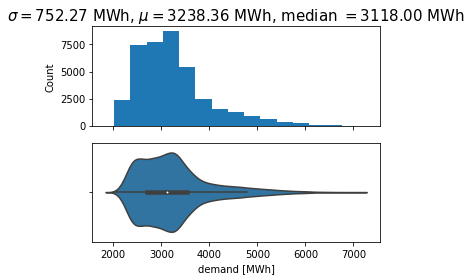

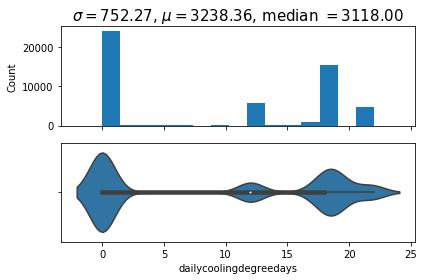

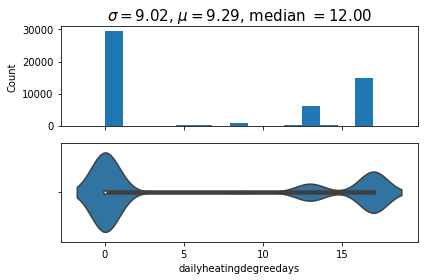

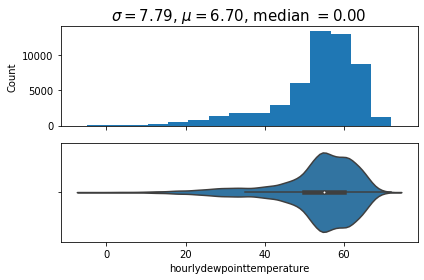

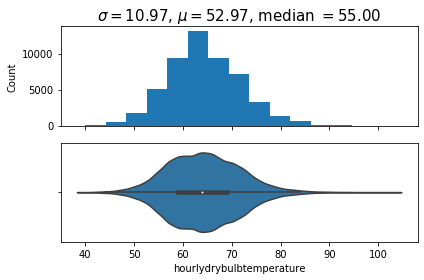

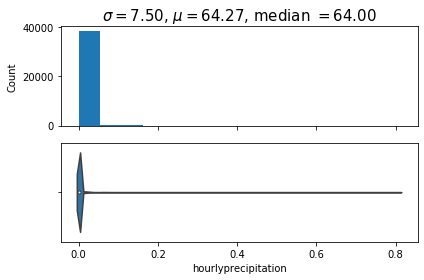

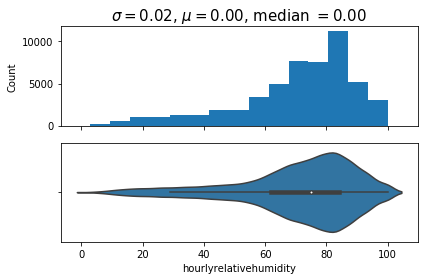

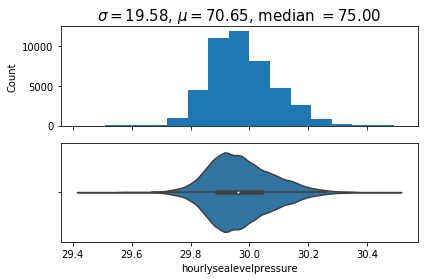

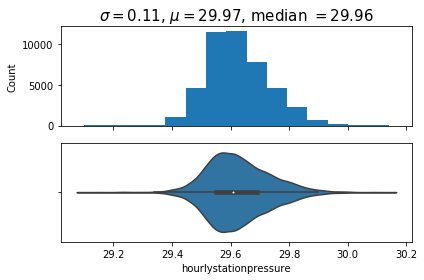

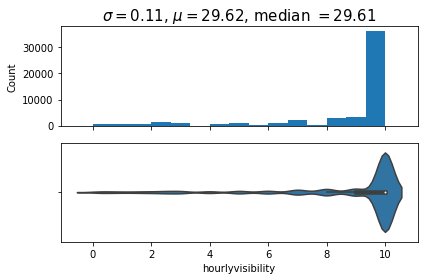

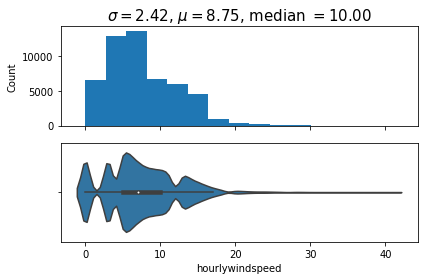

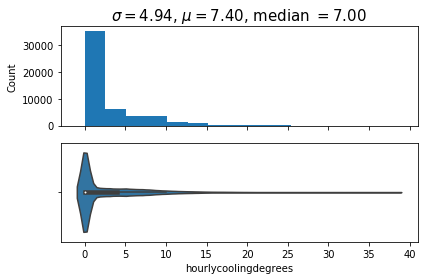

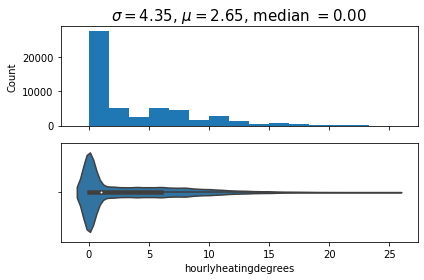

In [10]:
# plot histograms and violin plots as well as some stats for electricity data
for col in electricity_df.columns:
    fig,ax = plt.subplots(2, sharex=True)
    plot_data = electricity_df[col][~electricity_df[col].isnull()]
    ax[0].hist(plot_data, bins=15)
    title_text = r'$\sigma = %.2f$ MWh, $\mu = %.2f$ MWh, median $= %.2f$ MWh' % (plot_data.std(), plot_data.mean(), plot_data.median())
    sns.violinplot(plot_data, ax=ax[1])
    ax[0].set_ylabel('Count', labelpad=5)
    ax[1].set_xlabel('%s [MWh]' % col)
    ax[0].set_title(title_text, size=15)
    plt.tight_layout()
    plt.savefig('plots/distributions_%s/%s_dist.png' % (CITY, col), dpi=350)
    plt.show()
    plt.close()

# plot histograms and violin plots as well as some stats for weather data
for col in weather_df.columns:
    if col=='hourlyskyconditions': continue
    elif col=='hourlyprecip':
        title_text = r'$\sigma = %.2f$, $\mu = %.4f$, median $= %.4f$' % (plot_data.std(), plot_data.mean(), plot_data.median())
    else:
        title_text = r'$\sigma = %.2f$, $\mu = %.2f$, median $= %.2f$' % (plot_data.std(), plot_data.mean(), plot_data.median())
    plot_data = weather_df[col][~weather_df[col].isnull()]
    fig,ax = plt.subplots(2, sharex=True)
    ax[0].hist(plot_data, bins=15)
    sns.violinplot(plot_data, ax=ax[1])
    ax[0].set_ylabel('Count', labelpad=5)
    ax[1].set_xlabel('%s' % col)
    ax[0].set_title(title_text, size=15)
    plt.tight_layout()
    plt.savefig('plots/distributions_%s/%s_dist.png' % (CITY, col), dpi=350)
    plt.show()
    plt.close()

# plot bar plot for categorical value
weather_df['hourlyskyconditions'].value_counts().plot(kind='bar')
plt.close()

In [11]:
fill_dict = {'median': ['dailyheatingdegreedays', 'hourlyaltimetersetting', 'hourlydrybulbtemperature', 'hourlyprecipitation', 'hourlysealevelpressure', 'hourlystationpressure', 'hourlywetbulbtempf', 'dailycoolingdegreedays', 'hourlyvisibility', 'hourlywindspeed', 'hourlycoolingdegrees', 'hourlyheatingdegrees'], 'ffill': ['demand', 'hourlydewpointtempf', 'hourlyrelativehumidity']}

# fill electricity data NaNs
for col in cut_electricity.columns:
    if col in fill_dict['median']:
        cut_electricity[col].fillna(cut_electricity[col].median(), inplace=True)
    else:
        cut_electricity[col].fillna(cut_electricity[col].ffill(), inplace=True)

# fill weather data NaNs
for col in cut_weather.columns:
    if col == 'hourlyskyconditions':
        cut_weather[col].fillna(cut_weather[col].value_counts().index[0], inplace=True) 
    elif col in fill_dict['median']:
        cut_weather[col].fillna(cut_weather[col].median(), inplace=True)
    else:
        cut_weather[col].fillna(cut_weather[col].ffill(), inplace=True)


/Users/olavocarvalho/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Merging the dataframes

In [12]:
# finally merge the data to get a complete dataframe for LA, ready for training
merged_df = cut_weather.merge(cut_electricity, right_index=True, left_index=True, how='inner')

In [13]:
merged_df = pd.get_dummies(merged_df)

In [14]:
merged_df.head()

,dailycoolingdegreedays,dailyheatingdegreedays,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlysealevelpressure,hourlystationpressure,hourlyvisibility,hourlywindspeed,hourlycoolingdegrees,hourlyheatingdegrees,demand,hourlyskyconditions_,hourlyskyconditions_BKN,hourlyskyconditions_CLR,hourlyskyconditions_FEW,hourlyskyconditions_OVC,hourlyskyconditions_SCT,hourlyskyconditions_VV
datetime,,,,,,,,,,,,,,,,,,,,
2015-07-01 08:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.59,9.0,7.0,5.0,0.0,3298.0,0,1,0,0,0,0,0
2015-07-01 09:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.59,9.0,9.0,5.0,0.0,3045.0,0,1,0,0,0,0,0
2015-07-01 10:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.61,8.7,9.0,5.0,0.0,2892.0,0,1,0,0,0,0,0
2015-07-01 10:00:00+00:00,22.0,0.0,63.0,75.0,0.0,66.0,29.93,29.58,10.0,9.0,10.0,0.0,2892.0,0,1,0,0,0,0,0
2015-07-01 11:00:00+00:00,22.0,0.0,63.0,72.0,0.0,73.0,29.90,29.55,10.0,10.0,7.0,0.0,2787.0,0,1,0,0,0,0,0


In [15]:
merged_df.tail()

,dailycoolingdegreedays,dailyheatingdegreedays,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlysealevelpressure,hourlystationpressure,hourlyvisibility,hourlywindspeed,hourlycoolingdegrees,hourlyheatingdegrees,demand,hourlyskyconditions_,hourlyskyconditions_BKN,hourlyskyconditions_CLR,hourlyskyconditions_FEW,hourlyskyconditions_OVC,hourlyskyconditions_SCT,hourlyskyconditions_VV
datetime,,,,,,,,,,,,,,,,,,,,
2019-12-22 09:00:00+00:00,12.0,0.0,43.0,63.0,0.0,48.0,29.99,29.61,10.00,9.0,0.0,2.0,2506.0,0,1,0,0,0,0,0
2019-12-22 10:00:00+00:00,12.0,0.0,43.0,63.0,0.0,48.0,29.99,29.83,9.94,9.0,0.0,2.0,2396.0,0,1,0,0,0,0,0
2019-12-22 10:00:00+00:00,12.0,0.0,47.0,66.0,0.0,50.0,29.97,29.61,10.00,14.0,1.0,0.0,2396.0,0,1,0,0,0,0,0
2019-12-22 11:00:00+00:00,12.0,0.0,48.0,66.0,0.0,52.0,29.94,29.61,10.00,13.0,1.0,0.0,2326.0,0,1,0,0,0,0,0
2019-12-22 12:00:00+00:00,12.0,0.0,47.0,67.0,0.0,49.0,29.91,29.61,10.00,13.0,2.0,0.0,2276.0,0,1,0,0,0,0,0


In [16]:
merged_df.drop(['hourlyskyconditions_', 'hourlyskyconditions_VV'], axis=1, inplace=True)

In [17]:
cal = calendar()
holidays = cal.holidays(start=merged_df.index.min(), end=merged_df.index.max())

def create_timeseries_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['isbusinessday']=np.where(df.date.dt.weekday_name.isin(['Saturday','Sunday']),0,1)
    df['isholiday'] = df['date'].isin(holidays).astype(int)
    df['daylight'] = [1 if (hour >= 6 and hour <= 18) else 0 for hour in df['date'].dt.hour]
    return df


merged_df = create_timeseries_features(merged_df)

In [18]:
merged_df.head(150)

,dailycoolingdegreedays,dailyheatingdegreedays,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlysealevelpressure,hourlystationpressure,hourlyvisibility,hourlywindspeed,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isbusinessday,isholiday,daylight
datetime,,,,,,,,,,,,,,,,,,,,,
2015-07-01 08:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.59,9.00,7.0,...,2,3,7,2015,182,1,27,1,0,1
2015-07-01 09:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.59,9.00,9.0,...,2,3,7,2015,182,1,27,1,0,1
2015-07-01 10:00:00+00:00,22.0,0.0,63.0,70.0,0.0,79.0,29.93,29.61,8.70,9.0,...,2,3,7,2015,182,1,27,1,0,1
2015-07-01 10:00:00+00:00,22.0,0.0,63.0,75.0,0.0,66.0,29.93,29.58,10.00,9.0,...,2,3,7,2015,182,1,27,1,0,1
2015-07-01 11:00:00+00:00,22.0,0.0,63.0,72.0,0.0,73.0,29.90,29.55,10.00,10.0,...,2,3,7,2015,182,1,27,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-05 14:00:00+00:00,22.0,0.0,60.0,69.0,0.0,73.0,29.96,29.62,10.00,13.0,...,6,3,7,2015,186,5,27,0,0,1
2015-07-05 15:00:00+00:00,22.0,0.0,60.0,67.0,0.0,79.0,29.95,29.61,10.00,13.0,...,6,3,7,2015,186,5,27,0,0,1
2015-07-05 16:00:00+00:00,22.0,0.0,60.0,67.0,0.0,79.0,29.95,29.61,9.94,13.0,...,6,3,7,2015,186,5,27,0,0,1


In [19]:
# save as pickle file to continue in another notebook
merged_df.to_pickle('data/%s_dataset.pkl' % CITY)